(forecasting_with_ar)=
# Forecasting with Structural AR Timeseries

:::{post} Oct 20, 2022
:tags: forecasting, autoregressive, bayesian structural timeseries
:category: intermediate
:author: Nathaniel Forde
:::

Bayesian structural timeseries models are an interesting way to learn about the structure inherent in any observed timeseries data. It also gives us the ability to project forward the implied predictive distribution granting us another view on forecasting problems. We can treat the learned characteristics of the timeseries data observed to-date as informative about the structure of the unrealised future state of the same measure. 

In this notebook we'll see how to fit an predict a range of auto-regressive structural timeseries models and importantly how to predict future observations of the models.

In [1]:
import aesara as at
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import pyplot as plt

In [2]:
RANDOM_SEED = 8929
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Generate Fake Autoregressive Data

First we will generate a simple autoregressive timeseries. We will then show how to specify a model to fit this data and then add a number of complexities to the data and show how they too can be captured with an autoregressive model and used to predict the shape of the future.

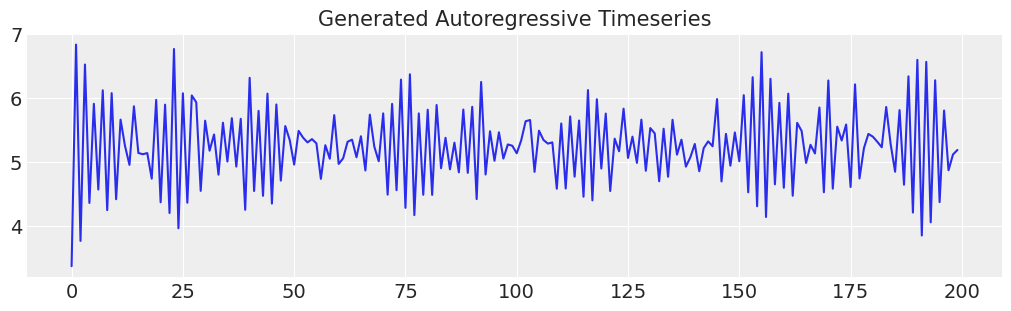

In [3]:
def simulate_ar(intercept, coef1, coef2, noise=0.3, *, warmup=10, steps=200):
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup + steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup + steps):
        draws[step] = (
            intercept
            + coef1 * draws[step - 1]
            + coef2 * draws[step - 2]
            + np.random.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]


ar1_data = simulate_ar(10, -0.9, 0)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Generated Autoregressive Timeseries", fontsize=15)
ax.plot(ar1_data);

## Specifying the Model

We'll walk through the model step by step and then generalise the pattern into a function that can be used to take increasingly complex structural combinations of components.

In [4]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.
priors = {"coefs": {"mu": 0, "size": 2}, "sigma": 1, "init": {"mu": 8, "sigma": 1, "size": 1}}

## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data = list(range(len(ar1_data)))
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data, mutable=True)

with AR:
    ## Data containers to enable prediction
    t = pm.MutableData("t", t_data, dims="obs_id")
    y = pm.MutableData("y", ar1_data, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], size=priors["coefs"]["size"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar1 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coefs"]["size"] - 1),
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y)
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, ar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 69 seconds.
Sampling: [likelihood]


In [5]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Lets check the model structure with plate notation and then examine the convergence diagnostics.

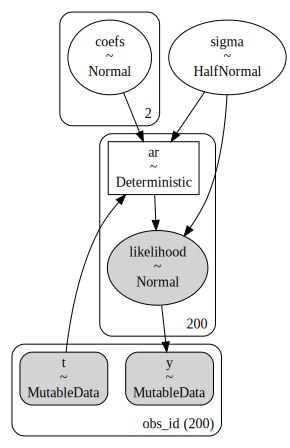

In [6]:
pm.model_to_graphviz(AR)

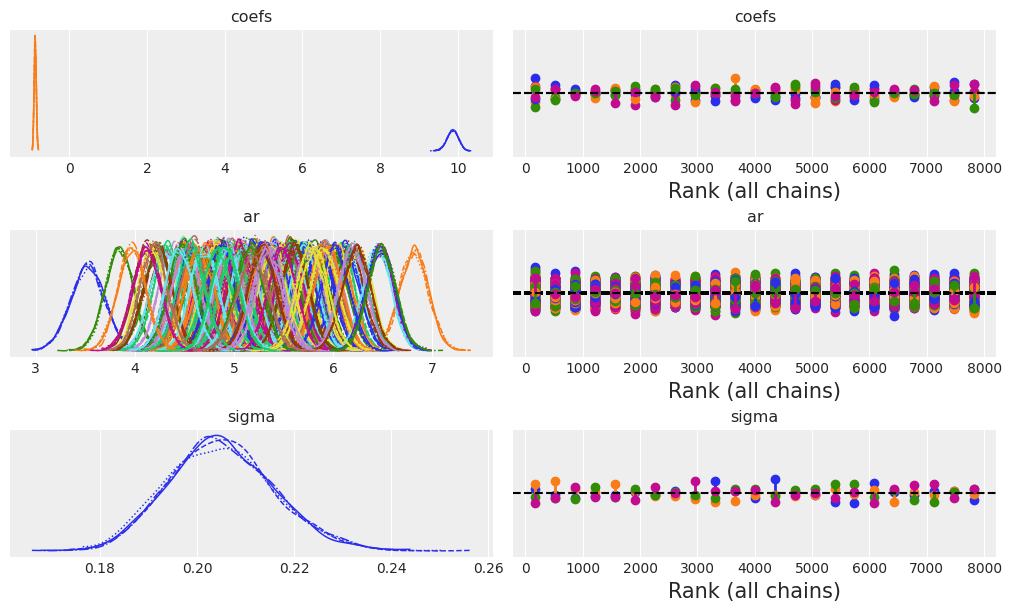

In [7]:
az.plot_trace(idata_ar, figsize=(10, 6), kind="rank_vlines");

Next we'll check the summary estimates for the to AR coefficients and the sigma term.

In [8]:
az.summary(idata_ar, var_names=["~ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],9.869,0.142,9.600,10.133,0.002,0.001,5343.0,5345.0,1.0
coefs[1],-0.879,0.026,-0.929,-0.831,0.000,0.000,5596.0,5774.0,1.0
sigma,0.205,0.011,0.185,0.225,0.000,0.000,3500.0,5874.0,1.0


## Prediction Step

The next step works much like generating posterior predictive observations for new data in a GLM model but with one additional complication that the AR process also expects "new" data. Or put another way, we have to tell the model how many prediction steps we want to impute with the model we have just fit. So for the shape handling purposes we have to feed our model the observed data and an appropriate range of null values.

In [9]:
prediction_length = 250
n = prediction_length - ar1_data.shape[0]
obs = list(range(prediction_length))
with AR:
    # update values of predictors pass in nans for number of extra predicted steps
    pm.set_data(
        new_data={"t": obs, "y": np.concatenate([ar1_data, np.array([np.nan for i in range(n)])])},
        coords={"obs_id": obs},
    )
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata_ar, var_names=["likelihood"], predictions=True, random_seed=100
    )

Sampling: [ar, likelihood]


In [10]:
idata_preds

Inference data with groups:
	> predictions
	> predictions_constant_data

## Inspecting model fit and forecast

We can look at the standard posterior predictive fits but since our data is timeseries data we have to also look how draws from the posterior predictive distribution vary over time.

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


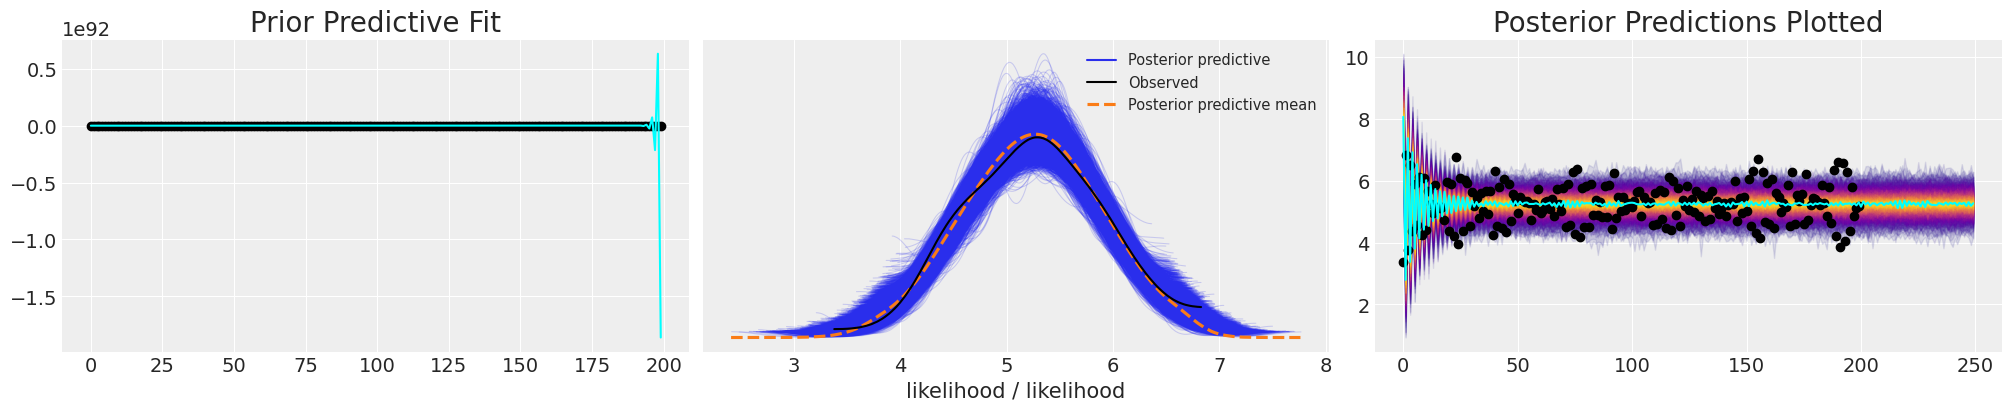

In [11]:
def plot_fits(idata_ar, idata_preds):
    palette = "plasma"
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

    fig, axs = plt.subplots(1, 3, sharex=False, figsize=(20, 4))
    axs = axs.flatten()
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract_dataset(idata_ar, group="prior_predictive", num_samples=100)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_ar, group="prior_predictive", num_samples=100)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[0].fill_between(
            x=idata_ar["constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[0].plot(
        az.extract_dataset(idata_ar, group="prior_predictive", num_samples=100)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
        label="Median Prediction",
    )

    axs[0].scatter(x=idata_ar["constant_data"]["t"], y=idata_ar["constant_data"]["y"], color="k")
    axs[0].set_title("Prior Predictive Fit", fontsize=20)

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=100)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=100)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions_constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[2].plot(
        az.extract_dataset(idata_preds, group="predictions", num_samples=100)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
    )
    axs[2].scatter(x=idata_ar["constant_data"]["t"], y=idata_ar["constant_data"]["y"], color="k")
    axs[2].set_title("Posterior Predictions Plotted", fontsize=20)
    # axs[2].set_ylim(0, 10)
    # axs[0].set_ylim(0, 10)
    az.plot_ppc(idata_ar, ax=axs[1])


plot_fits(idata_ar, idata_preds)

Here we can that although the model converged and ends up with a reasonable fit to the existing the data, and a **plausible  projection** for future values, we have set the prior specification very poorly in allowing an absurdly broad range of due to the kind of compoudning logic of the auto-regressive function. For this reason it's very important to be able to inspect and tailor your model with prior predictive checks. 

## Complicating the Picture

Let's add a trend to our data.

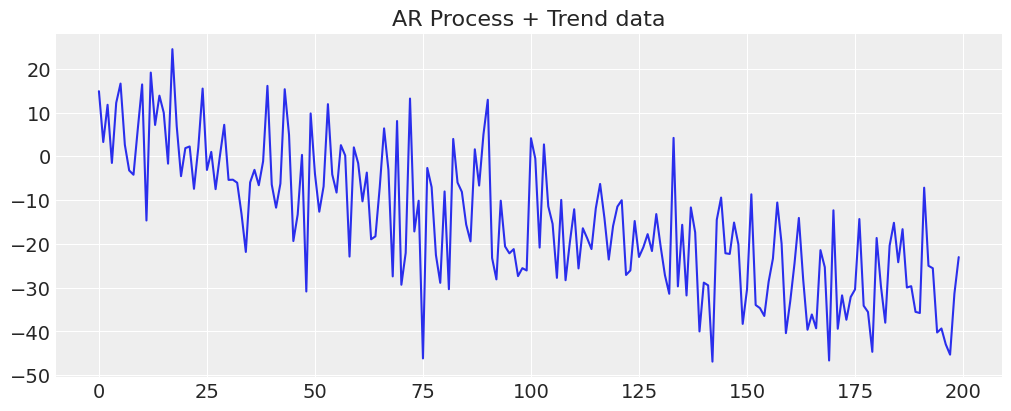

In [12]:
y_t = -0.3 + np.arange(200) * -0.2 + np.random.normal(0, 10, 200)
y_t = y_t + ar1_data

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_t)
ax.set_title("AR Process + Trend data");

### Wrapping our model into a function

In [13]:
def make_latent_AR_model(ar_data, priors, prediction_steps=250, full_sample=True, samples=2000):
    with pm.Model() as AR:
        pass

    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coefs_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
        coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            at.tensor.as_tensor_variable([coefs_0, coef_1]),
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
        )

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y)
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]

    with AR:
        # update values of predictors pass in nans for number of predicted steps
        pm.set_data(
            new_data={
                "t": list(range(prediction_steps)),
                "y": np.concatenate([ar_data, np.array([np.nan for i in range(n)])]),
            },
            coords={"obs_id": list(range(prediction_steps))},
        )
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

Next we'll cycle through a number of prior specifications to show how that impacts the prior predictive distribution.

In [14]:
priors_0 = {
    "coef_0": {"mu": -4, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
}

priors_1 = {
    "coef_0": {"mu": -2, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 12,
    "init": {"mu": 8, "sigma": 0.1, "size": 1},
}

priors_2 = {
    "coef_0": {"mu": 0, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 15,
    "init": {"mu": 8, "sigma": 0.1, "size": 1},
}

models = {}
for i, p in enumerate([priors_0, priors_1, priors_2]):
    models[i] = {}
    idata = make_latent_AR_model(y_t, p, full_sample=False)
    models[i]["idata"] = idata

Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Sampling: [ar, coef_0, coef_1, likelihood, sigma]


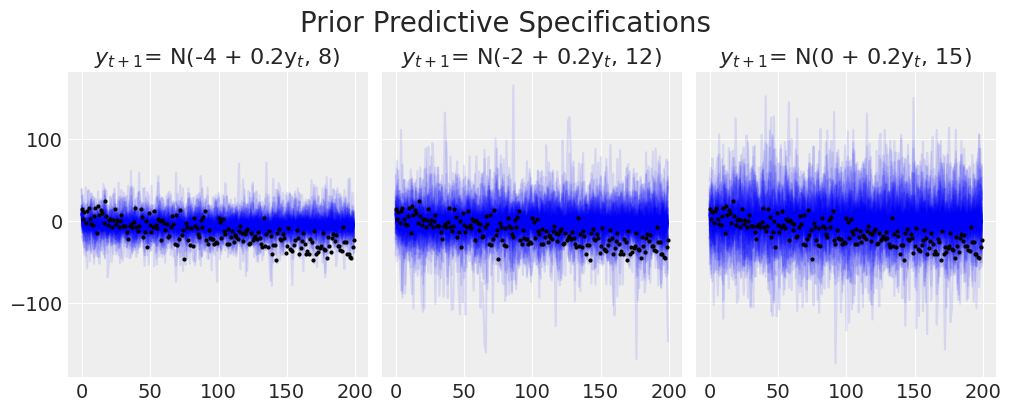

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axs = axs.flatten()
for i, p in zip(range(3), [priors_0, priors_1, priors_2]):
    axs[i].plot(
        az.extract_dataset(models[i]["idata"], group="prior_predictive", num_samples=100)[
            "likelihood"
        ],
        color="blue",
        alpha=0.1,
    )
    axs[i].plot(y_t, "o", color="black", markersize=2)
    axs[i].set_title(
        "$y_{t+1}$" + f'= N({p["coef_0"]["mu"]} + {p["coef_1"]["mu"]}y$_t$, {p["sigma"]})'
    )
plt.suptitle("Prior Predictive Specifications", fontsize=20);

We can see the manner in which the model struggles to capture the trend line.

In [16]:
priors_0 = {
    "coef_0": {"mu": -4, "sigma": 0.5, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}

idata_no_trend, preds_no_trend, model = make_latent_AR_model(y_t, priors_0)

Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
Sampling: [likelihood]


Sampling: [ar, likelihood]


/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


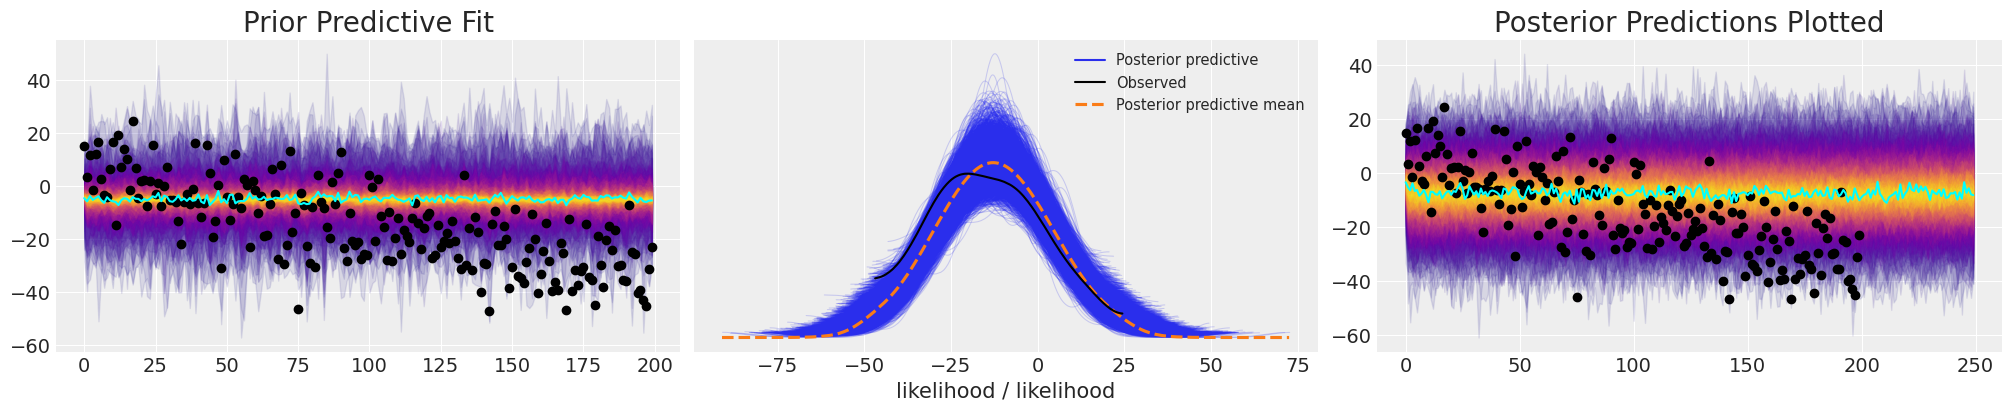

In [17]:
plot_fits(idata_no_trend, preds_no_trend)

Forecasting with this model is somewhat hopeless because, while the model fit adjusts the variance of the process to include the observed data, it completely fails to capture the structural trend in the data.

### Specifying a Trend Model

We will define a model to account for the trend in our data and combine this trend in a additive model with the autoregressive components. Again the model is much as before, but now we add additional latent features.

In [18]:
def make_latent_AR_trend_model(
    ar_data, priors, prediction_steps=250, full_sample=True, samples=2000
):
    with pm.Model() as AR:
        pass

    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coef_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
        coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            at.tensor.as_tensor_variable([coef_0, coef_1]),
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
        )

        ## Priors for the linear trend component
        alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
        beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
        trend = pm.Deterministic("trend", alpha + beta * t, dims="obs_id")

        mu = ar1 + trend

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]

    with AR:
        # update values of predictors pass in nans for number of predicted steps
        pm.set_data(
            new_data={
                "t": list(range(prediction_steps)),
                "y": np.concatenate([ar_data, np.array([np.nan for i in range(n)])]),
            },
            coords={"obs_id": list(range(prediction_steps))},
        )
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

We will fit this model by specifying priors on the negative trend and the range of the standard deviation to respect the direction of the data drift.

In [19]:
priors_0 = {
    "coef_0": {"mu": 0.2, "sigma": 0.5, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "alpha": {"mu": -4, "sigma": 0.1},
    "beta": {"mu": -0.5, "sigma": 0.1},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}


idata_trend, preds_trend, model = make_latent_AR_trend_model(y_t, priors_0, full_sample=True)

Sampling: [alpha, ar, beta, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.
Sampling: [likelihood]


Sampling: [ar, likelihood]


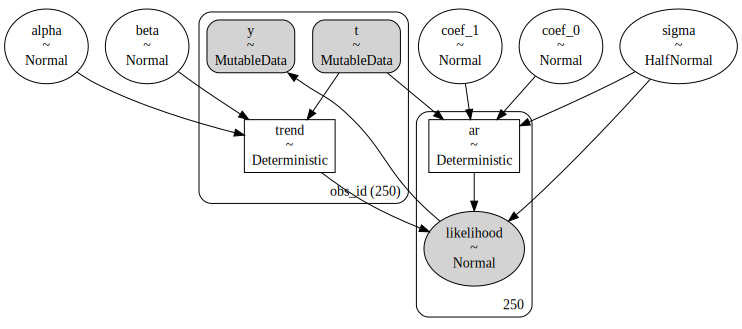

In [20]:
pm.model_to_graphviz(model)

We can see the structure more clearly with the plate notation, and this additional structure has helped to appropriately fit the directional trend of the timeseries data.

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


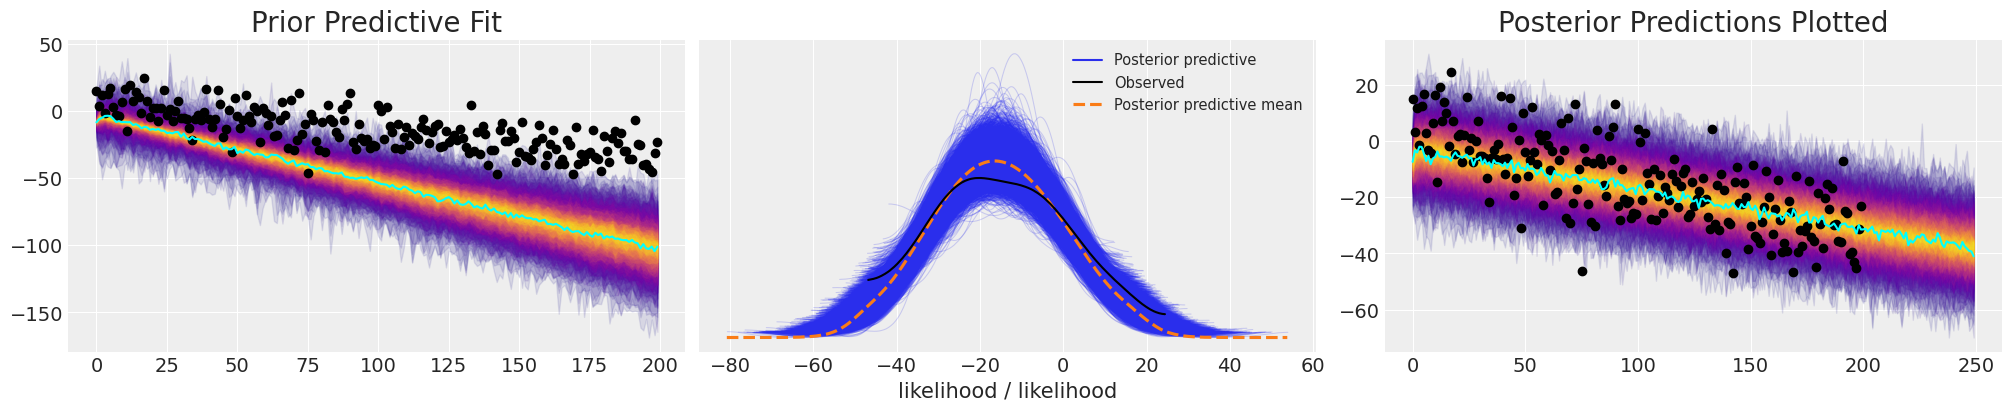

In [21]:
plot_fits(idata_trend, preds_trend);

In [22]:
az.summary(idata_trend, var_names=["coef_0", "coef_1", "sigma", "alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coef_0,0.980,0.477,0.075,1.846,0.009,0.007,2716.0,4237.0,1.0
coef_1,0.202,0.029,0.149,0.258,0.000,0.000,8691.0,6270.0,1.0
sigma,8.175,0.417,7.405,8.983,0.008,0.006,2760.0,5030.0,1.0
alpha,-3.975,0.100,-4.159,-3.785,0.001,0.001,8573.0,6514.0,1.0
beta,-0.142,0.009,-0.159,-0.125,0.000,0.000,1875.0,3968.0,1.0


## Complicating the picture further

Next we'll add a seasonal component to our data and see how we can recover this aspect of the data with a bayesian structural timeseries model.

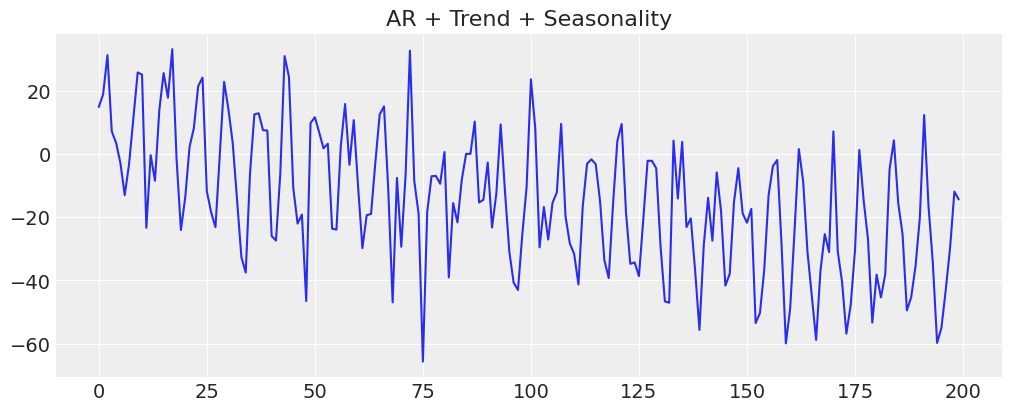

In [23]:
t_data = list(range(200))
n_order = 10
periods = np.array(t_data) / 7

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

y_t_s = y_t + 20 * fourier_features["sin_order_1"]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_t_s)
ax.set_title("AR + Trend + Seasonality");

The key to fitting this model is to understand that we're now passing in synthetic fourier features and that the model now expects a linear combination of those synthetic features even in the prediction step. As such we need to be able to supply those features even out into the future. This fact remains key for any other type of predictive feature we might want to add e.g. day of the week, holiday flag or any other. 

### Specifying the Trend + Seasonal Model

In [24]:
def make_latent_AR_trend_seasonal_model(
    ar_data, ff, priors, prediction_steps=250, full_sample=True, samples=2000
):
    with pm.Model() as AR:
        pass

    ff = ff.to_numpy().T
    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)
    ## The fourier features must be mutable to allow for addition fourier features to be
    ## passed in the prediction step.
    AR.add_coord("fourier_features", np.arange(len(ff)), mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coef_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
        coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            at.tensor.as_tensor_variable([coef_0, coef_1]),
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
        )

        ## Priors for the linear trend component
        alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
        beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
        trend = pm.Deterministic("trend", alpha + beta * t, dims="obs_id")

        ## Priors for seasonality
        beta_fourier = pm.Normal(
            "beta_fourier",
            mu=priors["beta_fourier"]["mu"],
            sigma=priors["beta_fourier"]["sigma"],
            dims="fourier_features",
        )
        fourier_terms = pm.MutableData("fourier_terms", ff)
        seasonality = pm.Deterministic(
            "seasonality", pm.math.dot(beta_fourier, fourier_terms), dims="obs_id"
        )

        mu = ar1 + trend + seasonality

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]
    n_order = 10
    periods = np.arange(prediction_steps) / 7

    fourier_features_new = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    with AR:
        # update values of predictors pass in nans for number of predicted steps
        pm.set_data(
            new_data={
                "t": list(range(prediction_steps)),
                "fourier_terms": fourier_features_new.to_numpy().T,
                "y": np.concatenate([ar_data, np.array([np.nan for i in range(n)])]),
            },
            coords={"obs_id": list(range(prediction_steps))},
        )
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

In [25]:
priors_0 = {
    "coef_0": {"mu": 0.2, "sigma": 0.5, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "alpha": {"mu": -4, "sigma": 0.1},
    "beta": {"mu": -0.5, "sigma": 0.1},
    "beta_fourier": {"mu": 0, "sigma": 0.8},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}


idata_t_s, preds_t_s, model = make_latent_AR_trend_seasonal_model(y_t_s, fourier_features, priors_0)

Sampling: [alpha, ar, beta, beta_fourier, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar, alpha, beta, beta_fourier]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 79 seconds.
Sampling: [likelihood]


Sampling: [ar, likelihood]


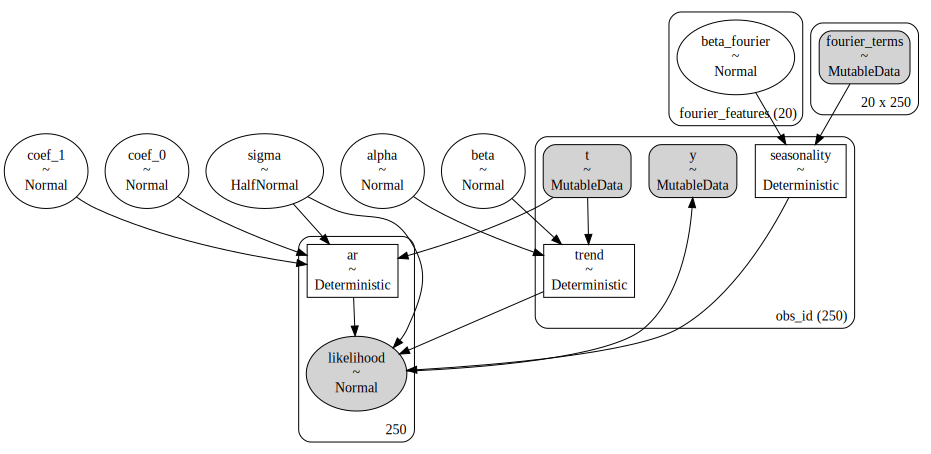

In [26]:
pm.model_to_graphviz(model)

In [27]:
az.summary(idata_t_s, var_names=["alpha", "beta", "coef_0", "coef_1", "beta_fourier"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-3.980,0.100,-4.174,-3.802,0.001,0.001,14836.0,5439.0,1.0
beta,-0.149,0.012,-0.172,-0.128,0.000,0.000,5267.0,5752.0,1.0
coef_0,0.729,0.480,-0.212,1.592,0.006,0.004,7082.0,6473.0,1.0
coef_1,0.211,0.029,0.157,0.266,0.000,0.000,15263.0,5363.0,1.0
beta_fourier[0],3.338,0.767,1.982,4.860,0.008,0.006,8988.0,6243.0,1.0
beta_fourier[1],-0.238,0.726,-1.630,1.079,0.006,0.008,14287.0,6459.0,1.0
beta_fourier[2],-0.036,0.719,-1.421,1.261,0.006,0.009,15387.0,6067.0,1.0
beta_fourier[3],0.160,0.721,-1.168,1.537,0.006,0.008,16403.0,6107.0,1.0
beta_fourier[4],-0.027,0.722,-1.438,1.231,0.006,0.009,15737.0,6387.0,1.0
beta_fourier[5],0.197,0.713,-1.143,1.514,0.006,0.008,15341.0,6299.0,1.0


/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


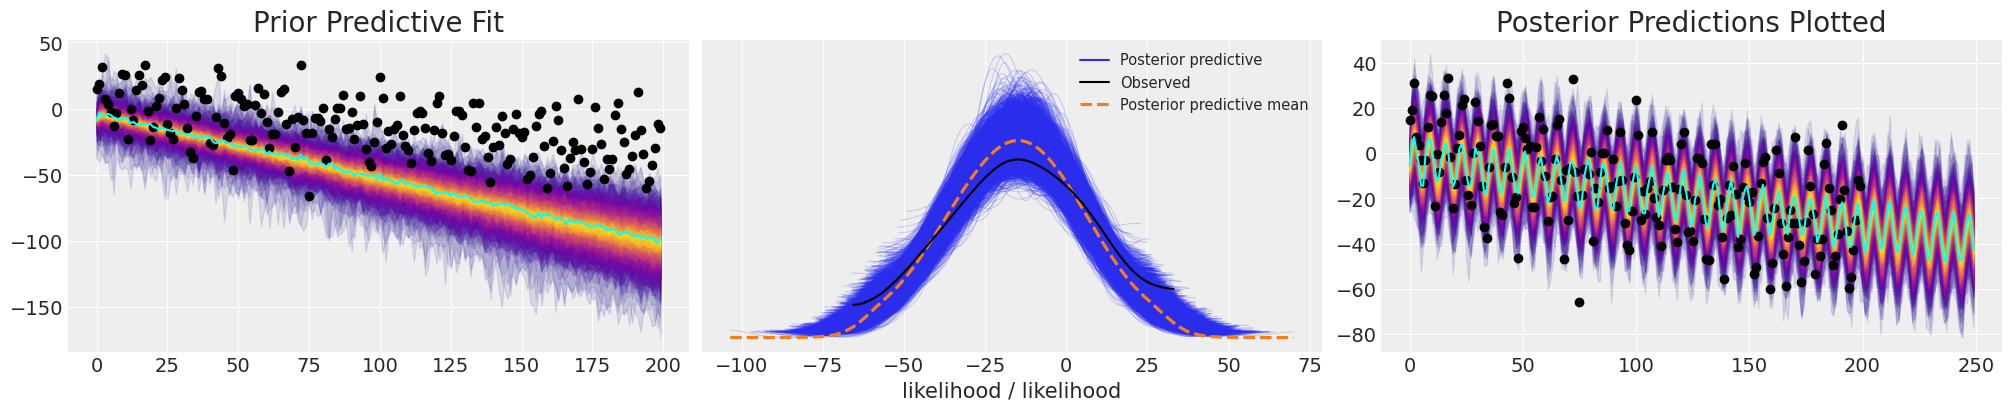

In [28]:
plot_fits(idata_t_s, preds_t_s)

We can see here how the the model fit again recovers the broad structure and trend of the data, but in addition we have captured the oscillation of the seasonal effect and projected that into the future.

## Authors

Adapted from Nathaniel Forde's [Examined Algorithms Blog](https://nathanielf.github.io/post/bayesian_structural_timeseries/) by Nathaniel Forde in Oct 2022.

## Watermark

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sat Oct 22 2022

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

aesara: 2.8.7
aeppl : 0.0.38
xarray: 2022.10.0

aesara    : 2.8.7
numpy     : 1.23.4
pandas    : 1.5.1
matplotlib: 3.6.1
sys       : 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]
pymc      : 4.2.2
arviz     : 0.12.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::